## 텐서플로 시작하기
- p120

## 상수 텐서와 변수
- 모두 1이거나 0인 텐서를 만들자

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [2]:
x = tf.zeros(shape=(2, 1))
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

## 랜덤 텐서

In [3]:
x = tf.random.normal(shape=(3, 1), mean = 0., stddev = 1.)
print(x)

tf.Tensor(
[[0.04606052]
 [0.7823014 ]
 [0.36337936]], shape=(3, 1), dtype=float32)


In [4]:
x = tf.random.uniform(shape=(3, 1), minval = 0., maxval = 1.)
print(x)

tf.Tensor(
[[0.96653676]
 [0.548499  ]
 [0.6712326 ]], shape=(3, 1), dtype=float32)


In [5]:
import numpy as np

x = np.ones(shape=(2, 2))
x[0, 0] = 0.
x

array([[0., 1.],
       [1., 1.]])

In [6]:
# x = tf.ones(shape=(2, 2))
# x[0, 0] = 0. # 할당 할 수 없음

In [7]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-1.1660553 ],
       [ 0.59083456],
       [ 0.29402784]], dtype=float32)>


In [8]:
v.assign(tf.ones((3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [9]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [10]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

## 텐서 연산: 텐서플로에서 사칙연산

In [11]:
a = tf.ones((2, 2))
b = tf.square(a) # 제곱 계산
c = tf.sqrt(a) # 제곱근 계산
d = b + c # 두 텐서를 더하기
e = tf.matmul(a, d)
e *= d
e

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[8., 8.],
       [8., 8.]], dtype=float32)>

# GradientTape API 살펴보기
- 텐서플로 numpy와 비슷
  + 미분가능하게 만들어줌 (텐서플로 0, numpy X)

In [12]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

In [13]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

In [14]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)
# 바깥쪽 테이프가 안쪽 테이프의 그레디언트를 계산합니다.
# 계산된 가속도는 4.9 * 2 = 9.8입니다.

## 엔드-투-엔드 예제
- 텐서플로 선형 분류기

### 2D 평면에 두 클래스 데이터 생성

In [15]:
num_samples_per_class = 1000

negative_sample = np.random.multivariate_normal(
    mean = [0, 3], # x축의 위치를 살짝 조정
    cov = [[1, 0.5], [0.5, 1]],
    size = num_samples_per_class
)

positive_sample = np.random.multivariate_normal(
    mean = [3, 0],
    cov = [[1, 0.5], [0.5, 1]], # 데이터 방향이 우상향
    size = num_samples_per_class
)

negative_sample

array([[ 0.68437749,  3.18041733],
       [-0.76722452,  1.95171393],
       [ 1.96576954,  4.84707845],
       ...,
       [ 0.51943212,  3.43066163],
       [-0.66062449,  1.61244803],
       [-0.49706281,  2.66706684]])

In [16]:
positive_sample.dtype

dtype('float64')

### 두 데이터 합치기

In [17]:
inputs = np.vstack((negative_sample, positive_sample)).astype(np.float32)
inputs.shape

(2000, 2)

## 0과 1로 구성된 타겟 생성

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))
targets.shape

(2000, 1)

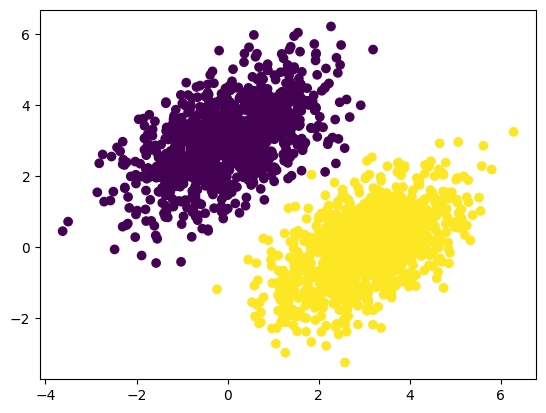

In [19]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

p. 127
- 선형 분류기
 = prediction = w * input + b

In [20]:
input_dim = 2  # 입력은 2차원 배열
output_dim = 1 # 출력 예측은 하나의 점수, 0에 가까우면 0, 1에 가까우면 1
# W = 균등분포에서 추출한 임의의 초기 기울기, 가중치
W = tf.Variable(initial_value = tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value = tf.zeros(shape=(output_dim,)))

## 정방향 패스 함수

In [21]:
def model(inputs):
  return tf.matmul(inputs, W) + b

## 평균 제곱 오차 손실 함수

In [22]:
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions) # 각 샘플의 손실 값을 담고 있다.
  return tf.reduce_mean(per_sample_losses) # 샘플당 손실 값으로 하나의 스칼라 손실 값으로 평균

## 훈련 스텝 함수
- 순전파 계산(=정방향 계산)
- 역전파 계산
- 가중치를 업데이트 = 기울기 변동 = 오차를 감소시키기 위한 목적

In [23]:
learning_rate = 0.1 # step

def training_step(inputs, targets):
  with tf.GradientTape() as tape: # 정방향 계산, 순전파 계산
    predictions = model(inputs)
    loss = square_loss(targets, predictions)
    # 역전파 수행 중, 각각의 업데이트 된 기울기(=가중치)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b]) # 경사하강법 / 역전파 수행 中
  W.assign_sub(grad_loss_wrt_W * learning_rate) # 가중치 업데이트
  b.assign_sub(grad_loss_wrt_b * learning_rate) # 회귀식으로 따지면 절편
  return loss

### 배치 훈련 루프

In [24]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"{step}번째 스텝의 손실: {loss:.4f}")

0번째 스텝의 손실: 4.9132
1번째 스텝의 손실: 0.8078
2번째 스텝의 손실: 0.2424
3번째 스텝의 손실: 0.1556
4번째 스텝의 손실: 0.1344
5번째 스텝의 손실: 0.1231
6번째 스텝의 손실: 0.1138
7번째 스텝의 손실: 0.1055
8번째 스텝의 손실: 0.0980
9번째 스텝의 손실: 0.0912
10번째 스텝의 손실: 0.0851
11번째 스텝의 손실: 0.0795
12번째 스텝의 손실: 0.0744
13번째 스텝의 손실: 0.0698
14번째 스텝의 손실: 0.0656
15번째 스텝의 손실: 0.0618
16번째 스텝의 손실: 0.0583
17번째 스텝의 손실: 0.0552
18번째 스텝의 손실: 0.0523
19번째 스텝의 손실: 0.0497
20번째 스텝의 손실: 0.0474
21번째 스텝의 손실: 0.0453
22번째 스텝의 손실: 0.0433
23번째 스텝의 손실: 0.0416
24번째 스텝의 손실: 0.0400
25번째 스텝의 손실: 0.0385
26번째 스텝의 손실: 0.0372
27번째 스텝의 손실: 0.0360
28번째 스텝의 손실: 0.0349
29번째 스텝의 손실: 0.0340
30번째 스텝의 손실: 0.0331
31번째 스텝의 손실: 0.0323
32번째 스텝의 손실: 0.0315
33번째 스텝의 손실: 0.0309
34번째 스텝의 손실: 0.0302
35번째 스텝의 손실: 0.0297
36번째 스텝의 손실: 0.0292
37번째 스텝의 손실: 0.0287
38번째 스텝의 손실: 0.0283
39번째 스텝의 손실: 0.0280


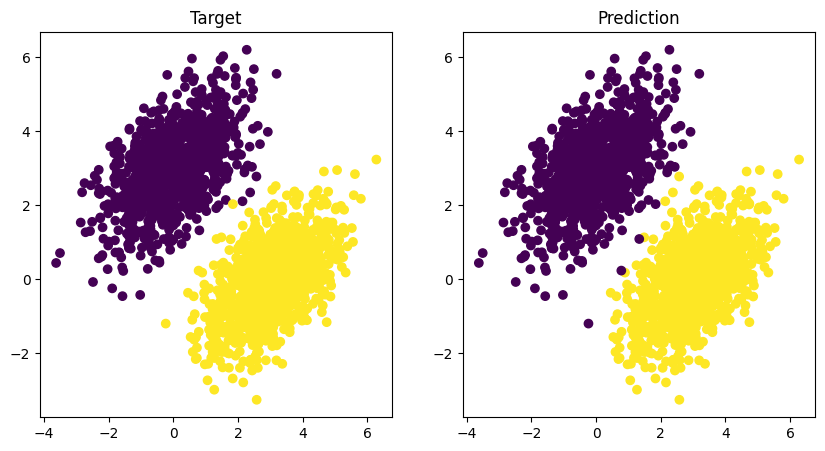

In [25]:
predictions = model(inputs)

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))

ax[0].scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
ax[0].set_title("Target")
ax[1].scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
ax[1].set_title("Prediction")
plt.show()

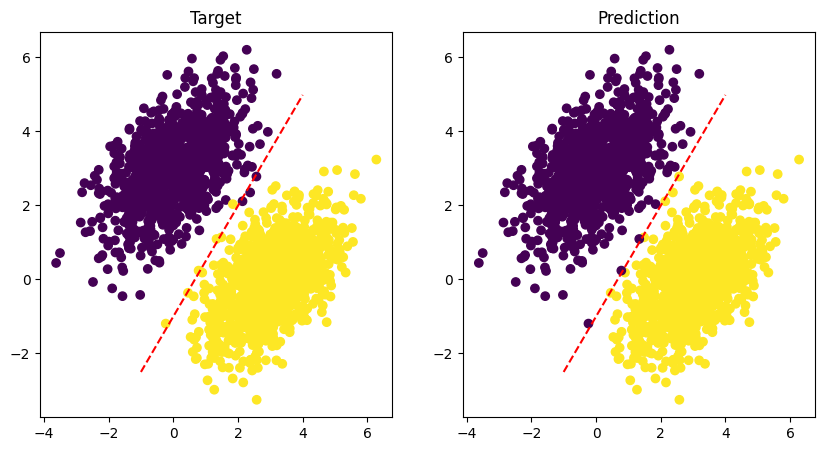

In [26]:
x = np.linspace(-1, 4, 100)
# 사실 100개의 x 축 좌표를 만들 필요 없이 시작과 종료 위치만 있어도 됩니다.
# x = [-1, 4]
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))

ax[0].scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
ax[0].set_title("Target")
ax[0].plot(x, y, '--r')

ax[1].scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
ax[1].set_title("Prediction")
ax[1].plot(x, y, '--r')
plt.show()

# 영화 리뷰 분류 : 이진 분류 문제
- p. 147

In [27]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [28]:
train_data[0][:3] # 형태소 분석, 텍스트 마이닝 할 때 나오는 숫자 개념

[1, 14, 22]

In [29]:
train_labels[0] # 부정적인 문장 0, 긍정적인 문장 1

1

In [30]:
max([max(sequence) for sequence in train_data]) # 가장 자주 등장하는 단어 1만개로 제한

9999

In [31]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)

decode_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[0]]
)

decode_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 정수 시퀀스를 멀티-핫 인코딩으로 인코딩
- p.149
 + 텍스트 데이터는 문장 길이가 다 달라서, 바로 행렬 변환이 어렵다.
 + 방법 1 : 같은 길이가 되도록 리스트에 패딩을 추가
 + 방법 2 : 멀티 핫 인코딩, 0과 1의 벡터로 변환

In [32]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [33]:
len(x_train[0]), len(x_train[1])

(10000, 10000)

In [34]:
x_train.shape

(25000, 10000)

In [35]:
x_test.shape

(25000, 10000)

## y갑 벡터 변환

In [36]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## 신경망 모델 만들기
- Dense 층을 쌓기
 + 얼마나 많은 층을 사용할 것인가?
 + 각층에 얼마나 많은 은닉층을 사용할 것인가?
 + 얼마나 많은 unit

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

# 모델 컴파일하기
model.compile(
    optimizer="rmsprop", # SGD 확률적 경사하강법
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

## 훈련 검증

In [38]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## 모델 훈련

In [39]:
history= model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 59ms/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4948
Epoch 2/20
30/30 [==============================] - 1s 26ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4948
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4948
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4948
Epoch 5/20
30/30 [==============================] - 1s 25ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4948
Epoch 6/20
30/30 [==============================] - 1s 27ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4948
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6931 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4948
Epoch 8/20
30

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 훈련과 검증 손실 그리기
- 해당 코드 함수화 할 것
  + 미니 과제

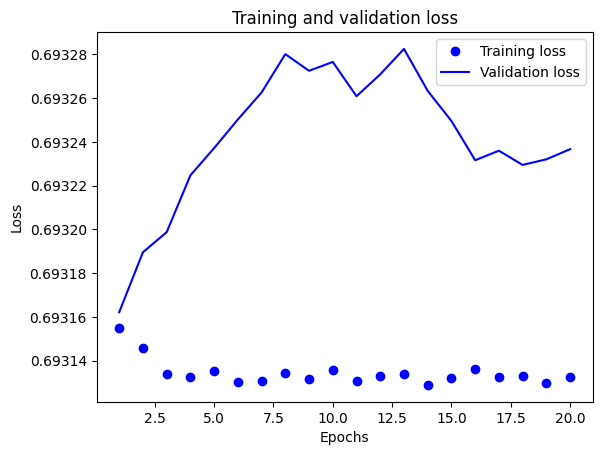

In [41]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 뉴스 기사 분류 : 다중분류 문제
- p. 160, 1986년 로이터 데이터셋
- 46개의 토픽 존재
- 10개의 샘플 존재

In [42]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

In [43]:
len(train_data)

8982

In [44]:
len(test_data)

2246

In [45]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [46]:
word_index = reuters.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)

decode_newswire = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[0]]
)

decode_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [48]:
train_labels # 토픽의 인덱스가 0~45 사이 정수

array([ 3,  4,  3, ..., 25,  3, 25])

In [49]:
train_labels[10]

3

## 인코딩
- (비유적)독립변수 전체를 벡터 변환

In [50]:
x_train = vectorize_sequences(train_data) # 훈련 데이터 벡터 변환
x_test = vectorize_sequences(test_data) # 훈련 데이터 벡터 변환

- 종속변수 전체 인코딩 ==> 범주형 인코딩

In [51]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [68]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

y_train.shape, y_test.shape #

((8982, 46), (2246, 46))

In [69]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [78]:
from tensorflow import keras
from tensorflow.keras import layers

'''
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])
'''
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax"), # 3개 이상 분류로 넘어가면 softmax (출력 노드)
])

# 모델 컴파일하기 (p.163)
model.compile(optimizer="rmsprop",
              # loss="categorical_crossentropy",
              loss="spqarse_categorical_crossentropy", # 1차원 배열, np.array(test_labels_copy)
              metrics=["accuracy"])

## 검증 세트 준비하기

In [76]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [80]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5, #20
                    batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/5


TypeError: ignored

### 모델 만들기


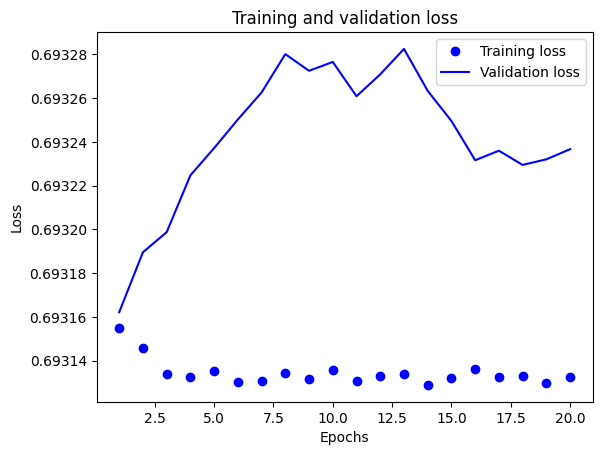

In [56]:
import matplotlib.pyplot as plt

loss= history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 모델 재훈련

In [57]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/5
16/16 [==============================] - 0s 25ms/step - loss: 3.4327 - accuracy: 0.3514 - val_loss: 3.4243 - val_accuracy: 0.3530
Epoch 2/5
16/16 [==============================] - 0s 19ms/step - loss: 3.4157 - accuracy: 0.3514 - val_loss: 3.4074 - val_accuracy: 0.3530
Epoch 3/5
16/16 [==============================] - 0s 20ms/step - loss: 3.3987 - accuracy: 0.3514 - val_loss: 3.3904 - val_accuracy: 0.3530
Epoch 4/5
16/16 [==============================] - 0s 17ms/step - loss: 3.3819 - accuracy: 0.3514 - val_loss: 3.3737 - val_accuracy: 0.3530
Epoch 5/5
16/16 [==============================] - 0s 19ms/step - loss: 3.3653 - accuracy: 0.3514 - val_loss: 3.3571 - val_accuracy: 0.3530


In [58]:
results = model.evaluate(x_test, y_test)
results

71/71 [==============================] - 0s 3ms/step - loss: 3.3636 - accuracy: 0.3615


[3.363614320755005, 0.3615316152572632]

In [59]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.19634906500445237

In [60]:
predictions = model.predict(x_test)
predictions[0].shape

71/71 [==============================] - 0s 2ms/step


(46,)

In [61]:
np.sum(predictions[0])

1.0

In [62]:
np.argmax(predictions[0])

19

In [63]:
y_train = np.array(train_labels) # 정수형태로 설정
y_test = np.array(test_labels)   # 정수형태로 설정

In [64]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [65]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax"), # 3개 이상 분류로 넘어가면 softmax (출력 노드)
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history= model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_test, y_test))

Epoch 1/9
16/16 [==============================] - 2s 40ms/step - loss: 3.8119 - accuracy: 0.2532 - val_loss: 3.7984 - val_accuracy: 0.3615
Epoch 2/9
16/16 [==============================] - 0s 20ms/step - loss: 3.7882 - accuracy: 0.3514 - val_loss: 3.7777 - val_accuracy: 0.3615
Epoch 3/9
16/16 [==============================] - 0s 19ms/step - loss: 3.7677 - accuracy: 0.3514 - val_loss: 3.7580 - val_accuracy: 0.3615
Epoch 4/9
16/16 [==============================] - 0s 22ms/step - loss: 3.7478 - accuracy: 0.3514 - val_loss: 3.7385 - val_accuracy: 0.3615
Epoch 5/9
16/16 [==============================] - 0s 24ms/step - loss: 3.7281 - accuracy: 0.3514 - val_loss: 3.7192 - val_accuracy: 0.3615
Epoch 6/9
16/16 [==============================] - 0s 22ms/step - loss: 3.7085 - accuracy: 0.3514 - val_loss: 3.6999 - val_accuracy: 0.3615
Epoch 7/9
16/16 [==============================] - 0s 29ms/step - loss: 3.6891 - accuracy: 0.3514 - val_loss: 3.6809 - val_accuracy: 0.3615
Epoch 8/9
16/16 [===

# 주택 가격 예측: 회귀 문제
- 1970년 중반 보스턴 외곽지역의 범죄율
- 각 특성

In [81]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [82]:
train_data.shape

(404, 13)

In [83]:
test_data.shape

(102, 13)

In [84]:
train_targets # 개별적인 수치 데이터

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 데이터 준비
- 정규화하기 : 상이한 스케일을 가진 값을 신경망에 주입하면 문제가 됨
- 질문 : 왜 테스트 데이터에 train의 평균과 표준편차를 적용 했는가?
- Data Leakage 반드시 공부 !!
  + 훈련 데이터 / 검증 데이터 / 테스트 데이터 의미만 잘 기억 !

In [85]:
mean = train_data.mean(axis=0)
mean

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [86]:
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

## 모델 구성
- 샘플개수가 적기 때문에 2개의 중간

In [99]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(1) # 수치 데이터 하나만 예측
  ])
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

## K-겹 검증 훈련 검증
- p.173

In [100]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print(f'#{i+1} 번째 폴드 처리중')
  # print(i * num_val_samples, (i+1) * num_val_samples)
  val_data = train_data[i * num_val_samples:(i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples:(i+1) * num_val_samples]
  # print(f"0:{i*num_val_samples}", f"{(i+1) * num_val_samples}:404")
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples], train_data[(i+1) * num_val_samples:]],
      axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples], train_targets[(i+1) * num_val_samples:]],
      axis=0
  )
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=16, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

all_scores

#1 번째 폴드 처리중
#2 번째 폴드 처리중
#3 번째 폴드 처리중
#4 번째 폴드 처리중


[1.9858018159866333,
 2.3371219635009766,
 2.4338583946228027,
 2.3765389919281006]

In [101]:
np.mean(all_scores)

2.2833302915096283

In [102]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"#{i}번째 폴드 처리중")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

#0번째 폴드 처리중
#1번째 폴드 처리중
#2번째 폴드 처리중
#3번째 폴드 처리중


In [103]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [107]:
np.mean(average_mae_history)

2.626562035858631

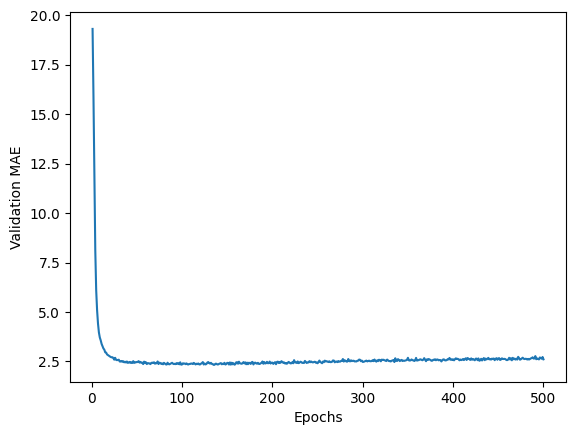

In [104]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()